# Generate bbox crops from ground truth

In [1]:
from fastai.vision.all import *

Download the dataset from https://www.mapillary.com/dataset/trafficsign (unfortunatelly manually – you need to provide your name and accept the license) and unpack them somewhere (see `path` below).

We will need these files:
- mtsd_fully_annotated_annotation.zip
- mtsd_fully_annotated_images.test.zip
- mtsd_fully_annotated_images.train.0.zip
- mtsd_fully_annotated_images.train.1.zip
- mtsd_fully_annotated_images.train.2.zip
- mtsd_fully_annotated_images.val.zip

In [2]:
# Mapillary dataset path:
path = Path('..')
# Where to put the cropped traffic signs (in separate subfolders for each label):
outpath = Path('yolo-bbox-crops-aspects-carla')

Let's do a quick sanity check on the unpacked data:

In [6]:
# if not (path/'carla-object-detection-dataset/traffic_signs_cleaned/labels/002111.txt').exists():
    # raise IOError(f"Missing annotations, please unpack them to: {path.absolute()}")
if not (path/'KITTI/training/label_2/000000.txt').exists():
    raise IOError(f"Missing annotations, please unpack them to: {path.absolute()}")

In [7]:
# if not (path/'carla-object-detection-dataset/traffic_signs_cleaned/images/002111.jpg').exists():
#     raise IOError(f"Missing images, please unpack them to: {path.absolute()}")
if not (path/'KITTI/training/image_2/000000.jpg').exists():
    raise IOError(f"Missing images, please unpack them to: {path.absolute()}")

In [5]:
with open(path/'carla-object-detection-dataset/traffic_signs_cleaned/autosplit_train.txt', 'r') as f:
    trnidx = [x.strip().split('/')[-1].split('.')[0] for x in f.readlines()]
# with open(path/'carla-object-detection-dataset/traffic_signs_cleaned/autosplit_val.txt', 'r') as f:
#     validx = [x.strip().split('/')[-1].split('.')[0] for x in f.readlines()]

In [6]:
trnidx[0]

'001364'

In [7]:
# label_names = ['Speed-Limit-30', 'Speed-Limit-30-US', 'Speed-Limit-40', 'Speed-Limit-60',
#           'Speed-Limit-60-US', 'Speed-Limit-90', 'Speed-Limit-90-US', 'Stop', 'Interchange',
#           'NoTurnsLeft', 'No-Turns', 'One-Way', 'One-Way-Left', 'Michigan-Left',
#           'Lane-Reduce-Left', 'One-Way-Right','Yield', 'AnimalCrossing']
label_names = ['Car', 'Cyclist', 'Pedestrian']

## Loading the bounding box annotations

In [8]:
def read_mapillary_annotation(idx, width=1280, height=768):
    with open(Path('../carla-object-detection-dataset/traffic_signs_cleaned/labels/')/(idx+'.txt')) as fd:
        lines = fd.readlines()
#     w,h = float(anno['width']), float(anno['height'])
        
    labels = []
    bboxes = []
    for line in lines:
        split_line = line.split(' ')
                
        labels.append(label_names[int(split_line[0])])
        x = float(split_line[1])
        y = float(split_line[2])
        w = float(split_line[3])
        h = float(split_line[4])
        x1 = x - w/2
        y1 = y - h/2
        x2 = x + w/2
        y2 = y + h/2
        bboxes.append([x1*width, y1*height, x2*width, y2*height])
#     for obj in anno['objects']:
#         bbox = obj['bbox']
#         bboxes.append([bbox['xmin'], bbox['ymin'], bbox['xmax'], bbox['ymax']])
#         labels.append(obj['label'])
    return dict(
        idx = idx, w = width, h = height, pano = False,
        labels = np.array(labels),
        bboxes = np.array(bboxes),
    )

In [9]:
read_mapillary_annotation(trnidx[0])

{'idx': '001364',
 'w': 1280,
 'h': 768,
 'pano': False,
 'labels': array(['Speed-Limit-60-US'], dtype='<U17'),
 'bboxes': array([[775., 347., 795., 372.]])}

Calculating width and height – we'll need it to get the aspect ratio of each sign. We are resizing (squishing) every sign into a 40x40 pixels square so remembering the original aspect ratio might be helpful.

In [10]:
bboxes = read_mapillary_annotation(trnidx[0])['bboxes']

In [11]:
wh = bboxes[:,2:] - bboxes[:,:2]
wh

array([[20., 25.]])

In [12]:
def create_crops(annotation, output_size=(40,40)):
    aspects = {}
    img = Image.open(f"../carla-object-detection-dataset/traffic_signs_cleaned/images/{annotation['idx']}.jpg")
    for i, (bbox, label) in enumerate(zip(annotation['bboxes'], annotation['labels'])):
        try:
            wh = bbox[2:] - bbox[:2]
            size = np.exp(np.log(wh).mean(-1))
            !mkdir -p {outpath}/{label}
            name = f"{label}/{annotation['idx']}-{i}.jpg"
            aspects[name] = wh[0]/wh[1]
            img.crop(bbox).resize(output_size).save(f"{outpath}/{name}")
        except:
            print(f"Skipping {annotation['idx']}-{i} / {label}")
    return aspects

First let's verify it works for just a couple of images:

In [13]:
!rm -r {outpath}

In [14]:
aspects = {k:v for idx in trnidx[:5] for k,v in create_crops(read_mapillary_annotation(idx)).items()}
aspects

{'Speed-Limit-60-US/001364-0.jpg': 0.8,
 'Speed-Limit-60-US/001365-0.jpg': 0.7666666666666705,
 'Speed-Limit-60-US/001366-0.jpg': 0.8000000000000033,
 'Speed-Limit-60-US/001367-0.jpg': 0.7777777777777778,
 'Speed-Limit-60-US/001368-0.jpg': 0.8000000000000019}

In [15]:
!ls -lR {outpath}

yolo-bbox-crops-aspects-traffic-signs:
total 4
drwxrwxr-x 2 vineet vineet 4096 Aug 31 07:12 Speed-Limit-60-US

yolo-bbox-crops-aspects-traffic-signs/Speed-Limit-60-US:
total 20
-rw-rw-r-- 1 vineet vineet 824 Aug 31 07:12 001364-0.jpg
-rw-rw-r-- 1 vineet vineet 864 Aug 31 07:12 001365-0.jpg
-rw-rw-r-- 1 vineet vineet 891 Aug 31 07:12 001366-0.jpg
-rw-rw-r-- 1 vineet vineet 945 Aug 31 07:12 001367-0.jpg
-rw-rw-r-- 1 vineet vineet 992 Aug 31 07:12 001368-0.jpg


Speed-Limit-60-US/001364-0.jpg
0.8


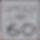

In [16]:
crop = list(aspects.keys())[0]
print(crop)
print(aspects[crop])
Image.open(f"{outpath}/{crop}")

## Generating all the cropped signs (in parallel)

In [17]:
!rm -r {outpath}

In [18]:
def make_crops(idx): return create_crops(read_mapillary_annotation(idx))

In [19]:
trn_aspects = parallel(make_crops, trnidx, progress=True)

In [20]:
val_aspects = parallel(make_crops, validx, progress=True)

In [21]:
all_aspects = {k:v for d in trn_aspects+val_aspects for k,v in d.items()}
len(all_aspects)

1531

In [22]:
pd.Series(all_aspects.values()).describe()

count    1531.000000
mean        1.164202
std         0.693804
min         0.560000
25%         0.793103
50%         0.943662
75%         1.034483
max         3.545455
dtype: float64

<AxesSubplot:>

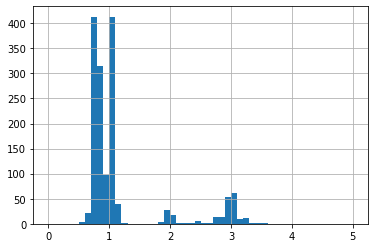

In [23]:
pd.Series(all_aspects.values()).hist(range=(0,5), bins=50)

In [24]:
pd.Series(all_aspects).to_csv('aspect-ratios.csv')